<a href="https://colab.research.google.com/github/bwsi-hadr/08-graph-optimization-tsp-hferguson0766/blob/master/08_Graph_Optimization_Problems_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (412 kB/s)
Selecting previously unselected package libspatialindex4

# Traveling Salesman Problem
The canonical Traveling Salesman Problem is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [0]:
place_name = 'Cambridge, MA, United States'
place_roads = ox.graph_from_place(place_name)


In [0]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

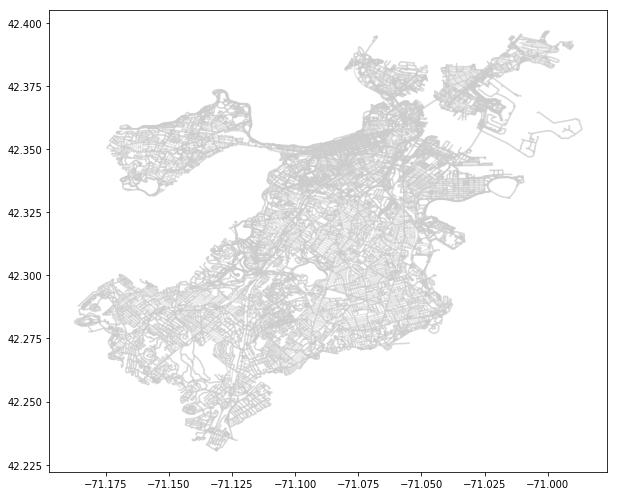

In [0]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [4]:
place_ice_cream = ox.pois_from_place(place_name, amenities=['ice_cream'])
place_ice_cream

,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,brand,brand:wikidata,brand:wikipedia,contact:email,cuisine,delivery,description,drive_through,element_type,email,geometry,name,opening_hours,osmid,outdoor_seating,phone,takeaway,toilets,toilets:access,website,wheelchair,wikidata
317333141,NaN,899,NaN,NaN,Main Street,ice_cream,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,node,NaN,POINT (-71.0994275 42.3635462),Toscanini's,Closed for construction,317333141,NaN,NaN,NaN,yes,customers,https://www.tosci.com/,no,Q7827577
480692709,NaN,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,NaN,NaN,no,NaN,no,node,NaN,POINT (-71.11749090000001 42.3728601),J. P. Licks,NaN,480692709,yes,NaN,yes,NaN,NaN,NaN,NaN,NaN
541316313,NaN,403,02139,NaN,Massachusetts Avenue,ice_cream,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,node,NaN,POINT (-71.1000483 42.3635902),New City Microcreamery,NaN,541316313,NaN,NaN,NaN,NaN,NaN,https://newcitymicrocreamery.com,NaN,NaN
1831393836,Cambridge,1255,02139,MA,Cambridge Street,ice_cream,NaN,NaN,NaN,iceandspice@comcast.net,ice_cream,NaN,NaN,no,node,NaN,POINT (-71.09838259999999 42.3735097),Christina's Homemade Ice Cream,Mo-Su 11:30-22:30,1831393836,NaN,+1-617-492-7021,NaN,NaN,NaN,http://christinasicecream.com/,NaN,NaN
5037446745,Somerville,415,02145,MA,Medford Street,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,contact@tippingcowicecream.com,POINT (-71.09941689999999 42.3914845),Tipping Cow,NaN,5037446745,NaN,+1-617-718-0558,NaN,NaN,NaN,https://www.tippingcowicecream.com,NaN,NaN
5695456136,NaN,36,NaN,NaN,Davis Square,ice_cream,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,node,NaN,POINT (-71.1224698 42.396944),J.P. Licks,Su-Th 11:00-23:00; Fr-Sa 11:00-24:00,5695456136,yes,NaN,yes,NaN,NaN,NaN,NaN,NaN
5916924485,Cambridge,159,02142,MA,First Street,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,NaN,POINT (-71.07816080000001 42.3660456),Toscanini's Ice Cream,Mo-Su 10:00-23:00,5916924485,NaN,+1 (617) 491-5877,NaN,NaN,NaN,https://www.tosci.com/,NaN,NaN
6101491948,NaN,NaN,NaN,NaN,NaN,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,NaN,POINT (-71.11979700000001 42.3831991),Honeycomb Creamery,"Su-Th 12:00-22:00; Fr,Sa 12:00-23:00",6101491948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6113522434,Somerville,626,NaN,MA,Somerville Avenue,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,node,NaN,POINT (-71.1107985 42.3838875),Forge Ice Cream Bar,Mo-Fr 14:00-21:00; Sa-Su 12:00-21:00,6113522434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6114610858,Cambridge,1668,02138,MA,Massachusetts Avenue,ice_cream,NaN,NaN,NaN,NaN,NaN,NaN,Frozen yogurt,NaN,node,NaN,POINT (-71.1199089 42.3820185),Berryline,Mo-Su 12:00-23:00,6114610858,NaN,+1 617 492 3555,NaN,NaN,NaN,http://www.berryline.com/,NaN,NaN


In [5]:
place_ice_cream['geometery']=place_ice_cream.centroid
ice_cream_nodes = ox.get_nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes

array([  61321277,   61324477, 5035889430,   61324518,   61323599,
         61322419,   61327141,   61322186,   71949065, 2559968283,
         61321986])

In [0]:
cambridge_bounds=Polygon.from_bounds(*place_roads_edges.total_bounds)
cambridge_bounds=cambridge_bounds.buffer(.001)
place_roads=ox.graph_from_polygon(cambridge_bounds)
place_roads_nodes, place_roads_edges=ox.graph_to_gdfs(place_roads)

## Exercise
Plot the locations of the ice cream shops on the map of the roads

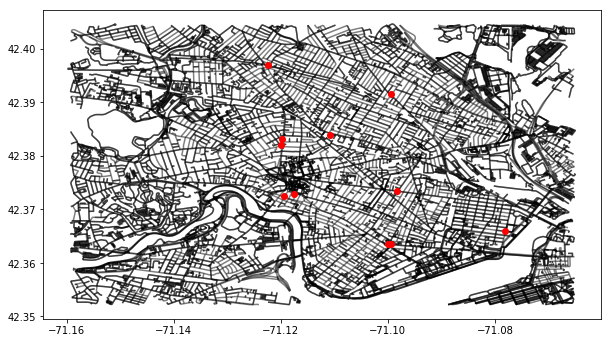

In [28]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=['black'], alpha=0.5)
place_ice_cream.plot(ax=ax, color=['red'], zorder=10)

## Compute shortest path matrix

In [6]:
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
  for idx_j, dest in enumerate(ice_cream_nodes):
    shortest_path_matrix[idx_i, idx_j] = nx.shortest_path_length(place_roads, orig, dest, weight='length')
shortest_path_matrix

array([[   0.   , 1835.064,   38.79 , 1299.504, 2957.854, 4847.869,
        2069.827, 3237.888, 3111.52 , 2966.392, 2102.05 ],
       [1934.426,    0.   , 1895.636, 1950.246, 1406.969, 3012.805,
        3899.601, 1402.824, 1430.635, 1131.328,  266.986],
       [  38.79 , 1796.274,    0.   , 1260.714, 2919.064, 4809.079,
        2108.617, 3199.098, 3072.73 , 2927.602, 2063.26 ],
       [1299.504, 1833.441, 1260.714,    0.   , 2044.09 , 4278.839,
        2239.096, 2668.858, 2197.756, 2397.362, 2047.607],
       [2767.483, 1464.731, 2728.693, 1892.825,    0.   , 2694.179,
        3987.245, 1087.763,  294.298,  816.267, 1530.058],
       [5009.625, 3144.763, 4970.835, 4299.985, 2595.916,    0.   ,
        6394.405, 1715.526, 2301.618, 1889.539, 3069.463],
       [2044.176, 3673.676, 2082.966, 2260.046, 4159.46 , 6394.209,
           0.   , 4784.228, 4313.126, 4512.732, 3940.662],
       [3294.099, 1429.237, 3255.309, 2584.459, 1109.983, 1902.676,
        4678.879,    0.   , 1011.024,  174.

In [0]:
ice_cream_graph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [31]:
# new graph indexes from 0
ice_cream_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

In [8]:
# rename node labels using original labels
ice_cream_graph = nx.relabel_nodes(ice_cream_graph,{k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)})
ice_cream_graph.nodes
#nx.draw_networkx_nodes(ice_cream_graph,pos=nx.kamada_kawai_layout(ice_cream_graph))

NodeView((61321277, 61324477, 5035889430, 61324518, 61323599, 61322419, 61327141, 61322186, 71949065, 2559968283, 61321986))

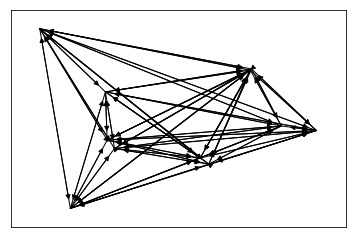

In [38]:
nx.draw_networkx_edges(ice_cream_graph,pos=nx.kamada_kawai_layout(ice_cream_graph))

## Exercise
Find the best TSP path you can

In [87]:
origin=np.random.choice(ice_cream_nodes)
node=origin
visited=[origin]
while(len(visited)<len(ice_cream_nodes)):
  minnum=9999999999
  endnode=0
  for x in ice_cream_graph.edges(node):
    num = ice_cream_graph.get_edge_data(x[0], x[1])[0]['weight']
    if num<minnum and (not x[1] in visited):
      minum=num
      endnode=x[1]
  node=endnode
  visited.append(node)
node=origin
visited.append(node)
print(visited)


[2559968283, 61321986, 71949065, 61322186, 61327141, 61322419, 61323599, 61324518, 5035889430, 61324477, 61321277, 2559968283]


[2559968283, 2559968303, 2559968299, 3306934506, 5645093170, 4116860973, 3306934554, 61333276, 5599241963, 328716271, 6104572109, 6124468256, 61324497, 61325469, 1839951958, 61321986, 61325428, 61325540, 61321985, 1839951959, 1839951958, 61329199, 61329615, 6124468256, 6104572109, 328716271, 5599241963, 61333276, 3306934554, 61327421, 61327430, 1096311805, 2559968287, 2559968298, 5617765742, 2562483349, 2562483350, 61323750, 61321384, 71949065, 61321639, 61323597, 2562486744, 2562483350, 2559968311, 6289135478, 61327517, 61328294, 61322177, 5458282497, 61322186, 2559968314, 2559968283, 2559968303, 2559968298, 5617765742, 2562483347, 6297995269, 454073373, 4470898296, 5147915565, 6298024752, 61321851, 314502422, 314502421, 314502416, 61328960, 61324878, 5458424288, 61324866, 61325472, 61325516, 61325635, 61325559, 61325634, 61324372, 61321284, 61326938, 61326736, 61321103, 61321101, 4616477686, 61317367, 61317365, 61317382, 61321032, 61321006, 61327356, 61327190, 61327330, 61327339, 613

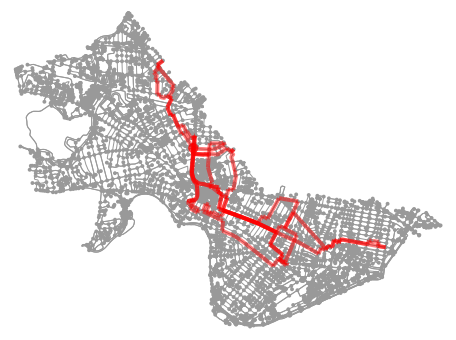

'\nfig = plt.figure(figsize=[10,10])\nax = fig.add_subplot(1,1,1)\nplace_roads_edges.plot(ax=ax, color=[\'black\'], alpha=0.5)\nG=nx.Graph()\n# a list of nodes:\nG.add_nodes_from(visited)\nx=0\nwhile x+1<len(visited):\n  \n  x+=1\nnx.draw(G)\nplt.savefig("simple_path.png") # save as png\nplt.show() # display\n'

In [88]:
rte=[]
x=0
while x<len(visited)-1:
  rte.append(nx.shortest_path(place_roads,visited[x],visited[x+1]))
  x+=1
flat_list = []
for sublist in rte:
    for item in sublist:
        if len(flat_list)==0 or item != flat_list[-1]:
          flat_list.append(item)
print(flat_list)
ox.plot_graph_route(place_roads, flat_list)

'''
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=['black'], alpha=0.5)
G=nx.Graph()
# a list of nodes:
G.add_nodes_from(visited)
x=0
while x+1<len(visited):
  
  x+=1
nx.draw(G)
plt.savefig("simple_path.png") # save as png
plt.show() # display
'''